In [1]:
# import sys
# !{sys.executable} -m pip install nltk

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# scipy sparse matrix
import scipy
from scipy.sparse import hstack

import matplotlib.pyplot as plt

from string import digits

import os

## *SKIP* Data Preprocessing & Data Cleaning

We use the full unprocessed URL here

In [3]:
df = pd.read_csv('../../URL_Classification.csv', header=None)
df.columns = ["index", "url", "label"]

num_samples = len(df)
df = df[0:num_samples]

In [4]:
df.head(15)

,index,url,label
0,1,http://www.liquidgeneration.com/,Adult
1,2,http://www.onlineanime.org/,Adult
2,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
3,4,http://www.galeon.com/kmh/,Adult
4,5,http://www.fanworkrecs.com/,Adult
5,6,http://www.animehouse.com/,Adult
6,7,http://www2.117.ne.jp/~mb1996ax/enadc.html,Adult
7,8,http://archive.rhps.org/fritters/yui/index.html,Adult
8,9,http://www.freecartoonsex.com/,Adult
9,10,http://www.cutepet.org/,Adult


## Labeling

In [5]:
unique_labels = list(set(df['label']))
unique_labels.sort()

label2idx = {unique_labels[k] : k for k in range(len(unique_labels))}
idx2label = {i: k for k, i in label2idx.items()}

In [6]:
label2idx

{'Adult': 0,
 'Arts': 1,
 'Business': 2,
 'Computers': 3,
 'Games': 4,
 'Health': 5,
 'Home': 6,
 'Kids': 7,
 'News': 8,
 'Recreation': 9,
 'Reference': 10,
 'Science': 11,
 'Shopping': 12,
 'Society': 13,
 'Sports': 14}

In [7]:
df['label'] = df['label'].map(label2idx)

## Bag of Words

In [8]:
bow_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(8, 8))

In [9]:
X = bow_vectorizer.fit_transform(df['url'].apply(lambda x: np.str_(x)))
y = df['label'].values

# data is still sorted
X, y = shuffle(X, y, random_state=67)

X.shape, y.shape

Training URL vectorizer...


((1562978, 11033225), (1562978,))

## Use SGDClassifier as SVM with optimized alpha

In [10]:
clf = sklearn.linear_model.SGDClassifier(loss='hinge',
                                         class_weight='balanced',
                                         alpha=1.3945578080387041e-06,
                                         max_iter=1000,
                                         verbose=0,
                                         n_jobs=-1,
                                         n_iter_no_change=60,
                                         average=32)

### Split train/test set to evaluate result

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123456)

In [12]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=1.3945578080387041e-06, average=32, class_weight='balanced',
              n_iter_no_change=60, n_jobs=-1)

In [13]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17625
           1       1.00      0.99      0.99    126809
           2       1.00      0.99      0.99    120375
           3       0.99      0.99      0.99     59326
           4       0.97      0.97      0.97     28142
           5       0.99      1.00      0.99     30064
           6       0.98      1.00      0.99     14221
           7       0.91      0.96      0.93     23081
           8       0.89      1.00      0.94      4460
           9       0.99      0.99      0.99     53221
          10       0.96      0.99      0.97     29248
          11       0.99      0.98      0.98     54895
          12       0.99      1.00      0.99     47599
          13       1.00      0.99      0.99    121975
          14       1.00      1.00      1.00     50448

    accuracy                           0.99    781489
   macro avg       0.98      0.99      0.98    781489
weighted avg       0.99   

In [14]:
y_pred = clf.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71     17700
           1       0.60      0.68      0.64    127031
           2       0.51      0.69      0.59    119802
           3       0.57      0.54      0.55     58636
           4       0.71      0.55      0.62     28335
           5       0.68      0.53      0.59     30033
           6       0.74      0.55      0.63     14048
           7       0.48      0.35      0.41     23101
           8       0.42      0.36      0.39      4529
           9       0.57      0.47      0.51     53365
          10       0.59      0.56      0.57     28999
          11       0.66      0.55      0.60     55391
          12       0.46      0.40      0.43     47671
          13       0.62      0.65      0.63    121968
          14       0.76      0.65      0.70     50880

    accuracy                           0.59    781489
   macro avg       0.61      0.54      0.57    781489
weighted avg       0.60   

normalize true / rows


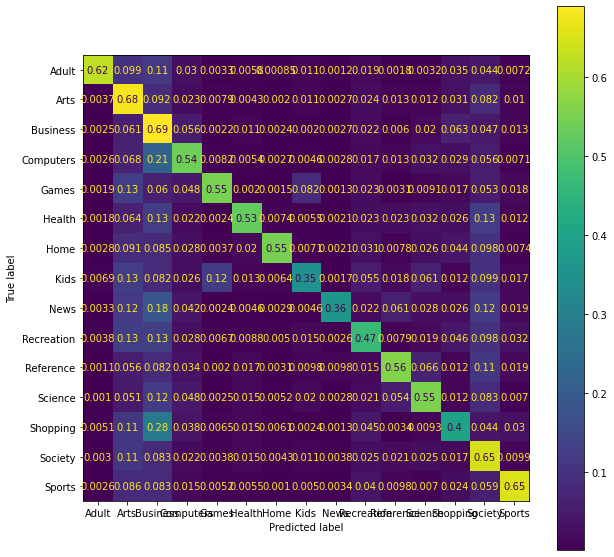

normalize pred / cols


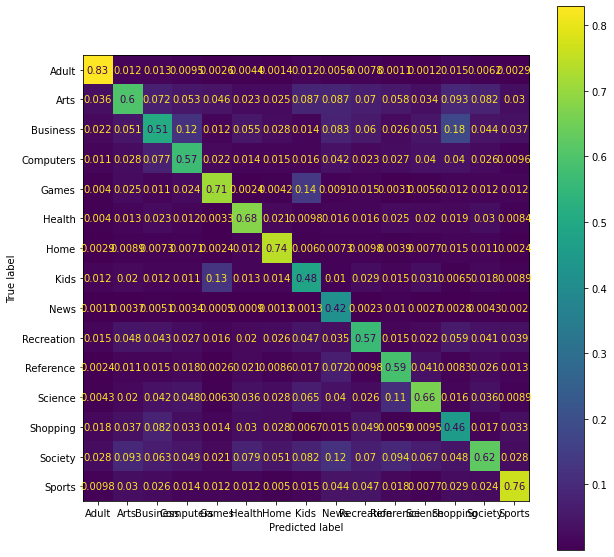

normalize all / cols + rows


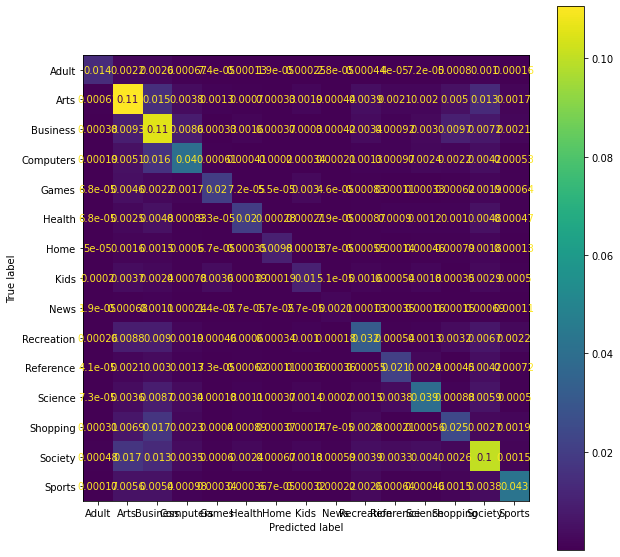

do not normalize


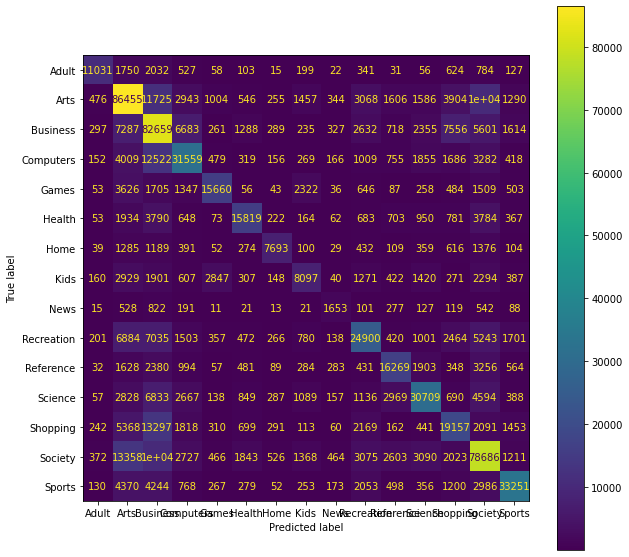

In [16]:
cm_true = confusion_matrix(y_test, y_pred, normalize='true', labels=[k for k in idx2label]) 
cm_pred = confusion_matrix(y_test, y_pred, normalize='pred', labels=[k for k in idx2label])
cm_all = confusion_matrix(y_test, y_pred, normalize='all', labels=[k for k in idx2label])
cm_none = confusion_matrix(y_test, y_pred, labels=[k for k in idx2label])


disp_true = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=unique_labels)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=unique_labels)
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=unique_labels)
disp_none = ConfusionMatrixDisplay(confusion_matrix=cm_none, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 10))
print('normalize true / rows')
disp_true.plot(include_values=True, ax=ax)
plt.show()

fig, bx = plt.subplots(figsize=(10, 10))
print('normalize pred / cols')
disp_pred.plot(include_values=True, ax=bx)
plt.show()

fig, cx = plt.subplots(figsize=(10, 10))
print('normalize all / cols + rows')
disp_all.plot(include_values=True, ax=cx)
plt.show()

fig, dx = plt.subplots(figsize=(10, 10))
print('do not normalize')
disp_none.plot(include_values=True, ax=dx)
plt.show()

In [ ]:
cvs = cross_val_score(clf, X, y, cv=3, scoring='f1_macro')
print(f'Mean {np.mean(cvs):.5f} \tVar {np.var(cvs):.5f}')
print(cvs)